# Laboratório de Processamento de Sinais para Comunicações
##  Prárica 04 - Filtragem Espacial

### Aluno - Matrícula:

Ezequias Márcio Silva de Santana Júnior - 371887

In [1]:
#!/usr/bin/env python3
import numpy as np 
from numpy.random import rand, randn
import matplotlib.pylab as plt
from numpy.linalg import eig, pinv
from scipy.signal import find_peaks
import time

In [65]:
# Funções:
def ula(N, d, theta):
    dx = np.arange(N)*d  # Indices dos espaçamentos "(nx-1)*dx"
    # Resposta do arranjo linear:
    return np.exp(-1j*2*np.pi*dx*np.sin(theta)).reshape(N, 1)

def get_angles(x, angles, theta):
    # Extração dos picos dos espectros espaciais:
    idx = find_peaks(x.reshape(x.size,), height=0.25)
    candidates = np.rad2deg(angles[idx[0]])
    ang = np.zeros(M)
    for idx, val in enumerate(theta):
        aux = abs(candidates-val)
        ang[idx] = candidates[(np.nonzero(aux==min(aux))[0][0])]
    return ang 

# Método da Correlação:
def corr_bf(X, angles):
    corr = np.zeros((angles.size, 1), dtype=complex)
    for idx, a in enumerate(angles):
        corr[idx] = np.conj(ula(X.shape[0], d, a)).T@X
    # Normalização:
    corr = np.abs(corr)
    return corr/(corr.max())

# Método Beamformer Convencional:
def conv_bf(X, angles):
    # Matriz de covariância estimada:
    mt_R = np.zeros((X.shape[1], X.shape[1]), dtype=complex)
    for t in range(X.shape[0]):
        mt_R += (X[t]@np.conj(X[t]).T)

    # Cálculo da matriz de covariância estimada:
    mt_R /= X.shape[0]
    # Espectro espacial:
    Pbf = np.zeros((angles.size, 1), dtype=complex)
    for idx, a in enumerate(angles):
        st_vec = ula(X.shape[1], d, a)
        Pbf[idx] = np.conj(st_vec).T@mt_R@st_vec/\
                   np.sqrt(np.conj(st_vec).T@st_vec)
    # Normalização:
    Pbf = np.abs(Pbf)
    return Pbf/(Pbf.max())

# Método MUSIC
def music_bf(X, angles, m):
    # Matriz de covariância estimada:
    mt_R = np.zeros((X.shape[1], X.shape[1]), dtype=complex)
    for t in range(X.shape[0]):
        mt_R += (X[t]@np.conj(X[t]).T)

    # Cálculo da matriz de covariância estimada:
    mt_R /= X.shape[0]
    # Decomposição em autovalores de R:
    evalue, evec = eig(mt_R)
    Uv = evec[:, m:]    # Subespaço do ruído
    # Espectro espacial:
    Pmsc = np.zeros((angles.size, 1), dtype=complex)
    for idx, a in enumerate(angles):
        st_vec = ula(X.shape[1], d, a)
        Pmsc[idx] = np.conj(st_vec).T@st_vec/\
                np.sqrt(np.conj(st_vec).T@Uv@np.conj(Uv).T@st_vec)
    # Normalização:    
    Pmsc = np.abs(Pmsc)
    return Pmsc/(Pmsc.max())

# Método ESPRIT:
def esprt_bf(X, m, d):
    # Matriz de covariância estimada:
    mt_R = np.zeros((X.shape[1], X.shape[1]), dtype=complex)
    for t in range(X.shape[0]):
        mt_R += (X[t]@np.conj(X[t]).T)

    # Cálculo da matriz de covariância estimada:
    mt_R /= X.shape[0]
    # Decomposição em autovalores de R:
    evalue, evec = eig(mt_R)
    # Estimação:
    Us = evec[:, :-(X.shape[1]-m)]    # Subespaço do sinal
    # mt_psi = pinv(Us[:-1, :]) @ Us[1:, :]
    mt_psi = pinv(Us[1:, :]) @ Us[:-1, :]
    val, vec = eig(mt_psi)
    angles = np.angle(val)
    # Retornando ângulos estimados:
    return np.rad2deg(np.sort(np.arcsin(angles/(2*np.pi*d))))


In [30]:
# Parâmetros:
snapshot = 500              # Snapshots
M = 3                       # Número de fontes de sinal
N = 10                      # Número de sensores do arranjo
d = 0.5                     # Espaçamento (lambda = 1)        
delta = np.radians(0.01)    # Passo para os ângulos
angles = np.arange(0, np.pi/2+delta, delta)    # Ângulos de Varredura [0,2pi]
snr = 10                    # Relação sinal-ruído [dB]
# Angulos de elevação, assumindo que o arranjo esteja no eixo x:
theta = np.array([20, 35, 65])
theta_r = np.radians(theta)
# Construção da matriz de resposta do arranjo:
mt_A = np.zeros((N,M), dtype=complex)
for idx, val in enumerate(theta_r):
    mt_A[:, [idx]] = ula(N, d, val)

# Modelo de sinal:
mt_X = np.zeros((snapshot, N, 1), dtype=complex)
# Para cada snapshot:
for t in range(snapshot):
    # Sinal de cada fonte:
    signal = rand(M, 1) + 1j*rand(M, 1)
    # Ruído de cada sensor:
    vt_n = (randn(N, 1) + 1j*randn(N, 1))/np.sqrt(10**(0.1*snr))
    # Sinal recebido no instante t:
    mt_X[t] = mt_A@signal + vt_n

mt_X.shape, mt_A.shape

((500, 10, 1), (10, 3))

In [41]:
# Método da Correlação:
# Cálculo da média dos dt primeiros snapshots: descomentar
# dt = 500
# c = np.zeros((dt, angles.size, 1))
# for i in range(dt):
#     c[i] = corr_bf(mt_X[i], angles)
# corr1 = np.mean(c, axis=0)

corr = corr_bf(mt_X[0], angles)


# Método Beamformer Convencional:
beamf = conv_bf(mt_X, angles)

# Método MUSIC
music = music_bf(mt_X, angles, M)

# Método ESPRIT:
esprit = esprt_bf(mt_X, M, d)


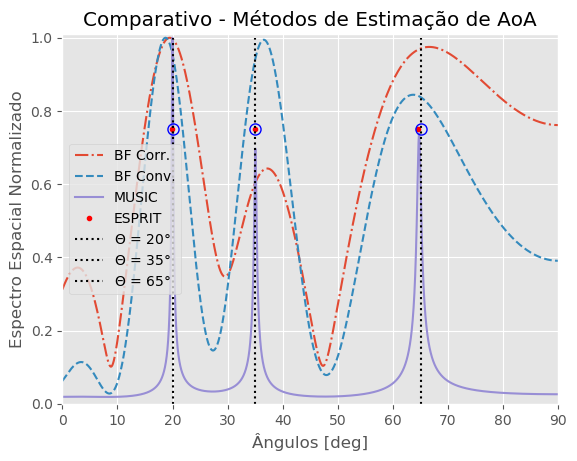

In [42]:
a = np.rad2deg(angles)
with plt.style.context('ggplot', True):
    plt.figure()
    plt.title('Comparativo - Métodos de Estimação de AoA')
    plt.xlabel('Ângulos [deg]')
    plt.ylabel('Espectro Espacial Normalizado')
    plt.plot(a, corr, '-.', label='BF Corr.')
#     plt.plot(a, corr1, '-.', label='BF Corr500.')
    plt.plot(a, beamf, '--', label='BF Conv.')
    plt.plot(a, music, '-', label='MUSIC')

    plt.plot(esprit, 0.75*(np.ones(M)), linestyle='none', marker='o', 
                                        color='r', 
                                        markersize=3, fillstyle='full', 
                                        label='ESPRIT')

    plt.plot(theta, 0.75*(np.ones(M)), linestyle='none', color='b', 
                                        marker='o', 
                                        markersize=8, fillstyle='none',) 
#                                         label='$\Theta$ Exato')
    # plt.grid()
    for value in theta:
        plt.plot(value*np.ones(100), np.linspace(0,1,100), 'k:', 
                 label=f'$\Theta$ = {value}°')
    # plt.xticks(np.arange(0, 91, 5))
    plt.axis([0, 90, 0, 1.01])
    plt.legend(loc='best')
    plt.show()

In [56]:
# RMSE vs SNR:
def sim_rmse(snr, mt_A, theta, angles):
    # Parâmetros:
    snapshot = 500              # Snapshots
    M = 3                       # Número de fontes de sinal
    N = 10                      # Número de sensores do arranjo
    d = 0.5                     # Espaçamento (lambda = 1)        
    realiz = 10     # Truncado devido ao custo computacional
    rmse = np.zeros((4, snr.size))
    for s in range(snr.size):
        for i in range(realiz):
#             print(f'Realização: {i+1} | SNR: {snr[s]}')
            snr_lin = 10**(0.1*snr[s])     # Relação sinal-ruído [lin]
            # Modelo de sinal:
            mt_X = np.zeros((snapshot, N, 1), dtype=complex)
            # Para cada snapshot:
            for t in range(snapshot):
                # Sinal de cada fonte:
                signal = rand(M, 1) + 1j*rand(M, 1)
                # Ruído de cada sensor:
                vt_n = (randn(N, 1) + 1j*randn(N, 1))/np.sqrt(snr_lin)
                # Sinal recebido no instante t:
                mt_X[t] = mt_A@signal + vt_n
            # Correlação:
            corr = corr_bf(mt_X[0], angles)
            # Tratamento dos angulos:
            ang_corr = get_angles(corr, angles, theta)
            
            # BF convencional:
            beamf = conv_bf(mt_X, angles)
            ang_beamf = get_angles(beamf, angles, theta)
                        
            # MUSIC:
            music = music_bf(mt_X, angles, M)
            ang_music = get_angles(music, angles, theta)
                       
            # ESPRIT:
            esprit = esprt_bf(mt_X, M, d)
 
            # Cálculo do RMSE
            rmse[0, s] += np.sqrt(np.mean((theta-ang_corr)**2))
            rmse[1, s] += np.sqrt(np.mean((theta-ang_beamf)**2))
            rmse[2, s] += np.sqrt(np.mean((theta-ang_music)**2))
            rmse[3, s] += np.sqrt(np.mean((theta-esprit)**2))
    # RMSE para cada snr:
    return rmse/realiz

snr = np.arange(0, 31, 5)
start = time.time()
erros = sim_rmse(snr, mt_A, theta, angles)
stop = time.time()
print('done', stop-start)

done 73.37423324584961


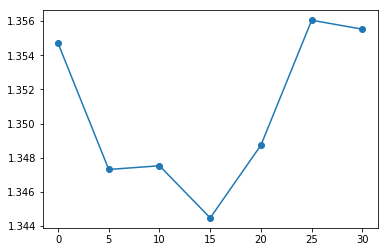

In [70]:
# Erros do Beamf. Convencional:
erros[1]
plt.plot(snr, erros[1, :], 'o-')


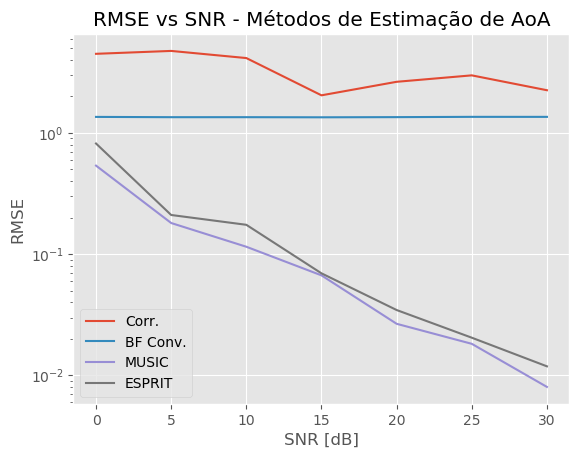

In [58]:
with plt.style.context('ggplot', True):
    plt.figure()
    plt.title('RMSE vs SNR - Métodos de Estimação de AoA')
    plt.xlabel('SNR [dB]')
    plt.ylabel('RMSE')
    plt.semilogy(snr, erros[0, :], label='Corr.')
    plt.semilogy(snr, erros[1, :], label='BF Conv.')
    plt.semilogy(snr, erros[2, :], label='MUSIC')
    plt.semilogy(snr, erros[3, :], label='ESPRIT')
    plt.legend(loc='best')
#     plt.savefig('per-snr100')
    plt.show()


In [61]:
# RMSE vs Snapshots:
def sim_rmse_snap(snapshots, mt_A, theta, angles):
    # Parâmetros:
    snr = 10                    # Relação sinal-ruído [dB]  
    M = 3                       # Número de fontes de sinal
    N = 10                      # Número de sensores do arranjo
    d = 0.5                     # Espaçamento (lambda = 1) 
    realiz = 10         # Truncado devido ao custo computacional
    rmse = np.zeros((4, snapshots.size))
    for s in range(snapshots.size):
        for i in range(realiz):
#             print(f'Realização: {i+1} | Snapsots: {snapshots[s]}')
            snr_lin = 10**(0.1*snr)     # Relação sinal-ruído [lin]
            # Modelo de sinal:
            mt_X = np.zeros((snapshots[s], N, 1), dtype=complex)
            # Para cada snapshot:
            for t in range(snapshots[s]):
                # Sinal de cada fonte:
                signal = rand(M, 1) + 1j*rand(M, 1)
                # Ruído de cada sensor:
                vt_n = (randn(N, 1) + 1j*randn(N, 1))/np.sqrt(snr_lin)
                # Sinal recebido no instante t:
                mt_X[t] = mt_A@signal + vt_n
            # Correlação:
            corr = corr_bf(mt_X[0], angles)
            # Tratamento dos angulos:
            ang_corr = get_angles(corr, angles, theta)
          
            # BF convencional:
            beamf = conv_bf(mt_X, angles)
            ang_beamf = get_angles(beamf, angles, theta)
                       
            # MUSIC:
            music = music_bf(mt_X, angles, M)
            ang_music = get_angles(music, angles, theta)
                    
            # ESPRIT:
            esprit = esprt_bf(mt_X, M, d)
           
            # Cálculo do RMSE
            rmse[0, s] += np.sqrt(np.mean((theta-ang_corr)**2))
            rmse[1, s] += np.sqrt(np.mean((theta-ang_beamf)**2))
            rmse[2, s] += np.sqrt(np.mean((theta-ang_music)**2))
            rmse[3, s] += np.sqrt(np.mean((theta-esprit)**2))
    # RMSE para cada snapshot:
    return rmse/realiz

snapshots = np.array([10, 20, 40, 80, 150, 300, 600, 1000])
start = time.time()
erroSnap = sim_rmse_snap(snapshots, mt_A, theta, angles)
stop = time.time()
print('done', stop-start)


done 77.38926529884338


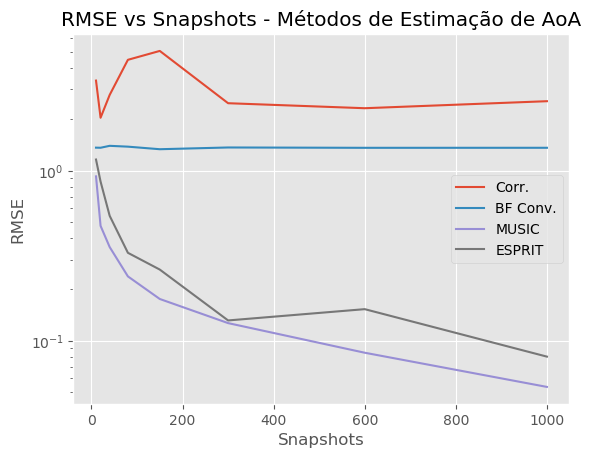

In [68]:
with plt.style.context('ggplot', True):
    plt.figure()
    plt.title('RMSE vs Snapshots - Métodos de Estimação de AoA')
    plt.xlabel('Snapshots')
    plt.ylabel('RMSE')
    plt.semilogy(snapshots, erroSnap[0, :], label='Corr.')
    plt.semilogy(snapshots, erroSnap[1, :], label='BF Conv.')
    plt.semilogy(snapshots, erroSnap[2, :], label='MUSIC')
    plt.semilogy(snapshots, erroSnap[3, :], label='ESPRIT')
    plt.legend(loc='best')
#     plt.savefig('per-snap100')
    plt.show()


In [71]:
# RMSE vs N:
def sim_rmse_n(Num, theta, angles):
    # Parâmetros:
    snapshot = 500              # Snapshots
    snr = 10                    # Relação sinal-ruído [dB]  
    snr_lin = 10**(0.1*snr)     # Relação sinal-ruído [lin]
    M = 3                       # Número de fontes de sinal
    d = 0.5                     # Espaçamento (lambda = 1)
    theta_r = np.radians(theta) # Ângulos das fontes [rad]

    realiz = 10    # Truncado devido ao custo computacional
    rmse = np.zeros((4, Num.size))
    for idn, valN in enumerate(Num):
        
        for i in range(realiz):
#             print(f'Realização: {i+1} | N: {valN}')
            # Modelo de sinal:
            mt_X = np.zeros((snapshot, valN, 1), dtype=complex)
            # Para cada snapshot:
            
            for t in range(snapshot):
                # Sinal de cada fonte:
                signal = rand(M, 1) + 1j*rand(M, 1)
                # Ruído de cada sensor:
                vt_n = (randn(valN, 1) + 1j*randn(valN, 1))/np.sqrt(snr_lin)
                # Construção da matriz de resposta do arranjo:
                mt_A = np.zeros((valN, M), dtype=complex)
                for idx, valT in enumerate(theta_r):
                    mt_A[:, [idx]] = ula(valN, d, valT)
                # Sinal recebido no instante t:
                mt_X[t] = mt_A@signal + vt_n
            # Correlação:
            corr = corr_bf(mt_X[0], angles)
            # Tratamento dos angulos:
            ang_corr = get_angles(corr, angles, theta)
            
            # BF convencional:
            beamf = conv_bf(mt_X, angles)
            ang_beamf = get_angles(beamf, angles, theta)
                       
            # MUSIC:
            music = music_bf(mt_X, angles, M)
            ang_music = get_angles(music, angles, theta)
                      
            # ESPRIT:
            esprit = esprt_bf(mt_X, M, d)
         
            # Cálculo do RMSE
            rmse[0, idn] += np.sqrt(np.mean((theta-ang_corr)**2))
            rmse[1, idn] += np.sqrt(np.mean((theta-ang_beamf)**2))
            rmse[2, idn] += np.sqrt(np.mean((theta-ang_music)**2))
            rmse[3, idn] += np.sqrt(np.mean((theta-esprit)**2))
    # RMSE para cada snapshot:
    return rmse/realiz

N = np.arange(5, 51, 5)
start = time.time()
erroN = sim_rmse_n(N, theta, angles)
stop = time.time()
print('done', stop-start)

done 116.15128374099731


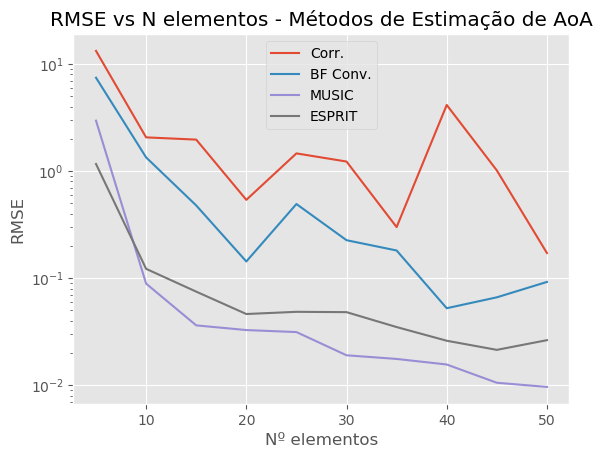

In [72]:
with plt.style.context('ggplot', True):
    plt.figure()
    plt.title('RMSE vs N elementos - Métodos de Estimação de AoA')
    plt.xlabel('Nº elementos')
    plt.ylabel('RMSE')
    plt.semilogy(N, erroN[0, :], label='Corr.')
    plt.semilogy(N, erroN[1, :], label='BF Conv.')
    plt.semilogy(N, erroN[2, :], label='MUSIC')
    plt.semilogy(N, erroN[3, :], label='ESPRIT')
    plt.legend(loc='best')
#     plt.savefig('per-N100')
    plt.show()